## Modelo (Optimizando Accuracy)

Importar Librerias

In [1]:
import pandas as pd
import numpy as np
import optuna
import mlflow
import mlflow.keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam



c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generar Variable Objetivo

In [2]:
# Carga del CSV
df = pd.read_csv("data2016modelo.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Variable objetivo
materias = [
    'punt_matematicas', 'punt_lectura_critica',
    'punt_ingles', 'punt_c_naturales', 'punt_sociales_ciudadanas'
]

# Features posibles
features_all = [
    'estu_genero', 'fami_educacionmadre', 'fami_educacionpadre',
    'fami_estratovivienda', 'fami_personashogar', 'fami_cuartoshogar',
    'fami_tieneautomovil', 'fami_tienecomputador',
    'fami_tieneinternet', 'fami_tienelavadora'
]

In [3]:
def objectiveAcc(trial):
    # ----------------------------------
    # 🔹 Selección de features (como antes)
    selected_features = [f for f in features_all if trial.suggest_categorical(f"usar_" + f, [True, False])]
    if not selected_features:
        return 0

    X = df[selected_features].copy()
    y = df['materia_menor_puntaje']

    for col in X.select_dtypes(include='object').columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    y_encoded = LabelEncoder().fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # ----------------------------------
    # 🔹 Hiperparámetros de red neuronal
    n_layers = trial.suggest_int("n_layers", 1, 4)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "elu"])
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Cantidad de neuronas por capa
    hidden_units = [trial.suggest_int(f"n_units_{i}", 32, 128) for i in range(n_layers)]

    # ----------------------------------
    # 🔹 Modelo dinámico
    model = Sequential()
    model.add(Dense(hidden_units[0], activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))

    for i in range(1, n_layers):
        model.add(Dense(hidden_units[i], activation=activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(5, activation='softmax'))

    # ----------------------------------
    # 🔹 Compilación y entrenamiento
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    with mlflow.start_run(nested=True):
        mlflow.log_params({
            "n_layers": n_layers,
            "activation": activation,
            "dropout": dropout_rate,
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "features": selected_features,
            **{f"n_units_{i}": hidden_units[i] for i in range(n_layers)}
        })

        model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=batch_size, verbose=0)
        loss, acc = model.evaluate(X_test, y_test, verbose=0)

        mlflow.log_metric("accuracy", acc)
        mlflow.keras.log_model(model, "modelo_keras")

    return acc
# ----------------------------------

In [4]:
import optuna
import mlflow
import json

# Configurar experimento en MLflow
mlflow.set_experiment("icfes_red_neuronal_optuna_Acc_Final")

# Crear y ejecutar el estudio
studyAcc = optuna.create_study(direction="maximize")
studyAcc.optimize(objectiveAcc, n_trials=5)

# Guardar los mejores hiperparámetros (excluyendo los booleanos "usar_<feature>")
mejores_params = {k: v for k, v in studyAcc.best_params.items() if not k.startswith("usar_")}

with open("mejores_params_modeloAcc.json", "w") as f:
    json.dump(mejores_params, f, indent=4)

print("✅ Mejores hiperparámetros guardados en 'mejores_params_modelo2.json'")


[I 2025-05-25 12:33:06,089] A new study created in memory with name: no-name-de1bd4a7-1979-407b-a046-d82961155489
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/05/25 12:37:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/25 12:37:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-05-25 12:37:46,212] Trial 0 finished with value: 0.2840137481689453 and parameters: {'usar_estu_genero': False, 'usar_fami_educacionmadre': True, 'usar_fami_educacionpadre': True, 'usar_fami_estratovivienda'

✅ Mejores hiperparámetros guardados en 'mejores_params_modelo2.json'


In [5]:
from sklearn.metrics import classification_report, f1_score

# Obtener los mejores parámetros del estudio
best_params = studyAcc.best_params
print("Mejores parámetros encontrados:")
print(json.dumps(best_params, indent=2))

# Recrear el modelo con los mejores parámetros
selected_features = [f for f in features_all if best_params.get(f"usar_{f}", False)]
print(f"\nFeatures seleccionadas: {selected_features}")

# Preparar datos con las mejores features
X = df[selected_features].copy()
y = df['materia_menor_puntaje']

# Encoding
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_encoded = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Crear el mejor modelo
model = Sequential()
model.add(Dense(best_params['n_units_0'], activation=best_params['activation'], input_shape=(X_train.shape[1],)))
model.add(Dropout(best_params['dropout']))

for i in range(1, best_params['n_layers']):
    model.add(Dense(best_params[f'n_units_{i}'], activation=best_params['activation']))
    model.add(Dropout(best_params['dropout']))

model.add(Dense(5, activation='softmax'))

# Compilar y entrenar
model.compile(optimizer=Adam(learning_rate=best_params['lr']),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=best_params['batch_size'], verbose=1)

# Evaluar
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"\n🎯 RESULTADOS DEL MEJOR MODELO:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Best trial value: {studyAcc.best_value:.4f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_classes))

Mejores parámetros encontrados:
{
  "usar_estu_genero": true,
  "usar_fami_educacionmadre": true,
  "usar_fami_educacionpadre": false,
  "usar_fami_estratovivienda": true,
  "usar_fami_personashogar": false,
  "usar_fami_cuartoshogar": true,
  "usar_fami_tieneautomovil": true,
  "usar_fami_tienecomputador": false,
  "usar_fami_tieneinternet": true,
  "usar_fami_tienelavadora": false,
  "n_layers": 4,
  "activation": "tanh",
  "dropout": 0.23937376534248514,
  "lr": 0.0016760748339264,
  "batch_size": 64,
  "n_units_0": 120,
  "n_units_1": 95,
  "n_units_2": 63,
  "n_units_3": 97
}

Features seleccionadas: ['estu_genero', 'fami_educacionmadre', 'fami_estratovivienda', 'fami_cuartoshogar', 'fami_tieneautomovil', 'fami_tieneinternet']
Epoch 1/20


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5604/5604 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.2963 - loss: 1.5457 - val_accuracy: 0.3111 - val_loss: 1.5268
Epoch 2/20
5604/5604 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3042 - loss: 1.5333 - val_accuracy: 0.2998 - val_loss: 1.5322
Epoch 3/20
5604/5604 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.3069 - loss: 1.5317 - val_accuracy: 0.3119 - val_loss: 1.5285
Epoch 4/20
5604/5604 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3042 - loss: 1.5324 - val_accuracy: 0.3068 - val_loss: 1.5280
Epoch 5/20
5604/5604 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3037 - loss: 1.5332 - val_accuracy: 0.3128 - val_loss: 1.5249
Epoch 6/20
5604/5604 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3058 - loss: 1.5327 - val_accuracy: 0.3118 - val_loss: 1.5265
Epoch 7/20
5604/5604 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3049 - loss: 1.5313 - val_accuracy: 0.3132 - val_loss: 1.5264
Epoch 8/20
5604/5604 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3041 - loss: 1.5328 - val

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Guardar en h5 y pkl


In [6]:
import pickle

# Guardar el modelo entrenado en formato .h5
model.save('mejor_modelo_f1.h5')

# Guardar el scaler y otros componentes necesarios en formato .pkl

# Guardar el scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Guardar las features seleccionadas
with open('selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

# Guardar el label encoder para la variable objetivo
label_encoder_y = LabelEncoder()
label_encoder_y.fit(y)
with open('label_encoder_y.pkl', 'wb') as f:
    pickle.dump(label_encoder_y, f)

# Guardar los mejores parámetros en formato pickle también
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

print("✅ Modelo y componentes guardados exitosamente:")
print("- mejor_modelo_f1.h5 (modelo de Keras)")
print("- scaler.pkl (StandardScaler)")
print("- selected_features.pkl (features seleccionadas)")
print("- label_encoder_y.pkl (codificador de variable objetivo)")
print("- best_params.pkl (mejores parámetros)")

✅ Modelo y componentes guardados exitosamente:
- mejor_modelo_f1.h5 (modelo de Keras)
- scaler.pkl (StandardScaler)
- selected_features.pkl (features seleccionadas)
- label_encoder_y.pkl (codificador de variable objetivo)
- best_params.pkl (mejores parámetros)


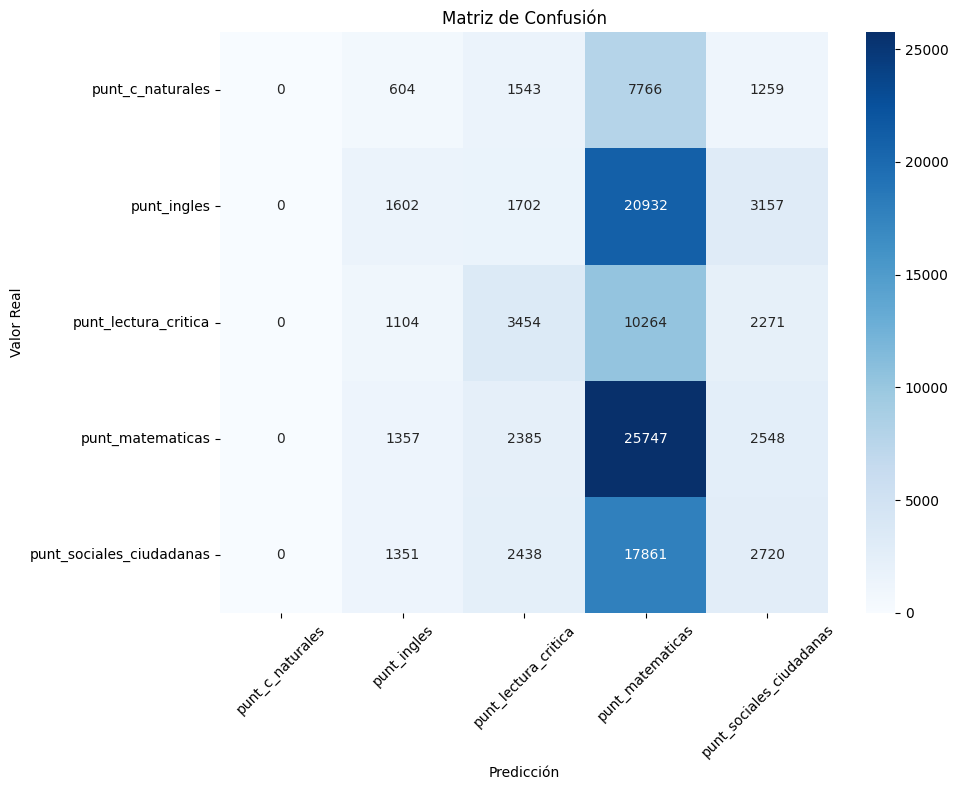

Matriz de Confusión:
[[    0   604  1543  7766  1259]
 [    0  1602  1702 20932  3157]
 [    0  1104  3454 10264  2271]
 [    0  1357  2385 25747  2548]
 [    0  1351  2438 17861  2720]]

Clases: ['punt_c_naturales' 'punt_ingles' 'punt_lectura_critica'
 'punt_matematicas' 'punt_sociales_ciudadanas']


In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Crear la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

# Obtener las etiquetas de las clases
class_labels = label_encoder_y.classes_

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Mostrar también los valores numéricos
print("Matriz de Confusión:")
print(cm)
print(f"\nClases: {class_labels}")